# Exercise 3 Solution: Two-Strain Model

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/epistorm/tech-transfer-epydemix/blob/main/sessions/session-4/solutions/python/exercise_3_two_strains.ipynb)

Model the emergence of a more transmissible variant using a multi-strain SIR model.

In [1]:
# Colab installation (skip if running locally)
import sys, os, subprocess
if "google.colab" in sys.modules or os.getenv("COLAB_RELEASE_TAG"):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-r",
                    "https://raw.githubusercontent.com/epistorm/epydemix/refs/heads/main/tutorials/colab_requirements.txt"])

## Model Structure

We model two strains where strain 2 is more transmissible:

**Compartments:** S, I₁, I₂, R₁, R₂

**Transitions:**
- $S + I_1 \rightarrow 2I_1$ (rate β) — infection with strain 1
- $S + I_2 \rightarrow 2I_2$ (rate β·ψ) — infection with strain 2 (ψ > 1)
- $R_1 + I_2 \rightarrow I_2 + R_2$ (rate β·ψ·γ) — reinfection of R₁ by strain 2
- $I_1 \rightarrow R_1$ (rate μ) — recovery from strain 1
- $I_2 \rightarrow R_2$ (rate μ) — recovery from strain 2

**Parameters:**
- ψ = transmissibility advantage of strain 2
- γ = relative susceptibility of R₁ to strain 2 (1 = fully susceptible, 0 = fully protected)

## Task 1: Implement the Two-Strain Model

In [2]:
from epydemix import EpiModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("Dark2")

def create_two_strain_model(psi=1.5, gamma=0.4, beta=0.20, mu=0.1):
    """Create a two-strain SIR model.
    
    Args:
        psi: Transmissibility advantage of strain 2 (>1 means more transmissible)
        gamma: Relative susceptibility of R1 to strain 2 (0-1)
        beta: Base transmission rate
        mu: Recovery rate (same for both strains)
    """
    model = EpiModel(name="Two-Strain SIR", compartments=["S", "I1", "I2", "R1", "R2"])
    
    # S + I1 → 2I1 (infection with strain 1)
    model.add_transition(source="S", target="I1", kind="mediated", params=("beta", "I1"))
    
    # S + I2 → 2I2 (infection with strain 2, more transmissible)
    model.add_transition(source="S", target="I2", kind="mediated", params=("beta*psi", "I2"))
    
    # R1 + I2 → I2 + R2 (reinfection: R1 individuals can be infected by strain 2)
    model.add_transition(source="R1", target="I2", kind="mediated", params=("beta*psi*gamma", "I2"))
    
    # I1 → R1 (recovery from strain 1)
    model.add_transition(source="I1", target="R1", kind="spontaneous", params="mu1")
    
    # I2 → R2 (recovery from strain 2)
    model.add_transition(source="I2", target="R2", kind="spontaneous", params="mu2")
    
    # Set parameters
    model.add_parameter("beta", beta)
    model.add_parameter("psi", psi)
    model.add_parameter("gamma", gamma)
    model.add_parameter("mu1", mu)
    model.add_parameter("mu2", mu)
    
    return model

# Create the model
model = create_two_strain_model(psi=1.5, gamma=0.4)
print(model)

EpiModel(name='Two-Strain SIR')
Compartments: 5
  S, I1, I2, R1, R2
Transitions: 5
  Transitions between compartments:
    S -> I1, params: ('beta', 'I1') (kind: mediated)
    S -> I2, params: ('beta*psi', 'I2') (kind: mediated)
    R1 -> I2, params: ('beta*psi*gamma', 'I2') (kind: mediated)
    I1 -> R1, params: mu1 (kind: spontaneous)
    I2 -> R2, params: mu2 (kind: spontaneous)
Parameters: 5
  Model parameters:
    beta: 0.2
    psi: 1.5
    gamma: 0.4
    mu1: 0.1
    mu2: 0.1
Population: epydemix_population
  Population size: 100000 individuals
  Demographic groups: 1
    0



## Task 2: Delay Strain 2 Emergence

We use `override_parameter` to "turn off" strain 2 for the first 30 days by setting its transmissibility (ψ) and recovery rate (μ₂) to zero.

In [3]:
# Override parameters to delay strain 2 emergence
# Setting psi=0 means strain 2 cannot transmit
# Setting mu2=0 means I2 individuals don't recover (they stay "dormant")
model.override_parameter(
    start_date="2025-01-01",
    end_date="2025-01-31",  # First 30 days
    parameter_name="psi",
    value=0.0
)

model.override_parameter(
    start_date="2025-01-01",
    end_date="2025-01-31",
    parameter_name="mu2",
    value=0.0
)

## Task 3: Simulate and Visualize

In [4]:
# Run simulations
results = model.run_simulations(
    start_date="2025-01-01",
    end_date="2025-07-31",  # 6 months
    Nsim=50,
    initial_conditions_dict={
        "S": model.population.Nk - np.ones(1) * 20,
        "I1": np.ones(1) * 10,
        "I2": np.ones(1) * 10,  # Dormant until day 30
        "R1": np.zeros(1),
        "R2": np.zeros(1)
    }
)

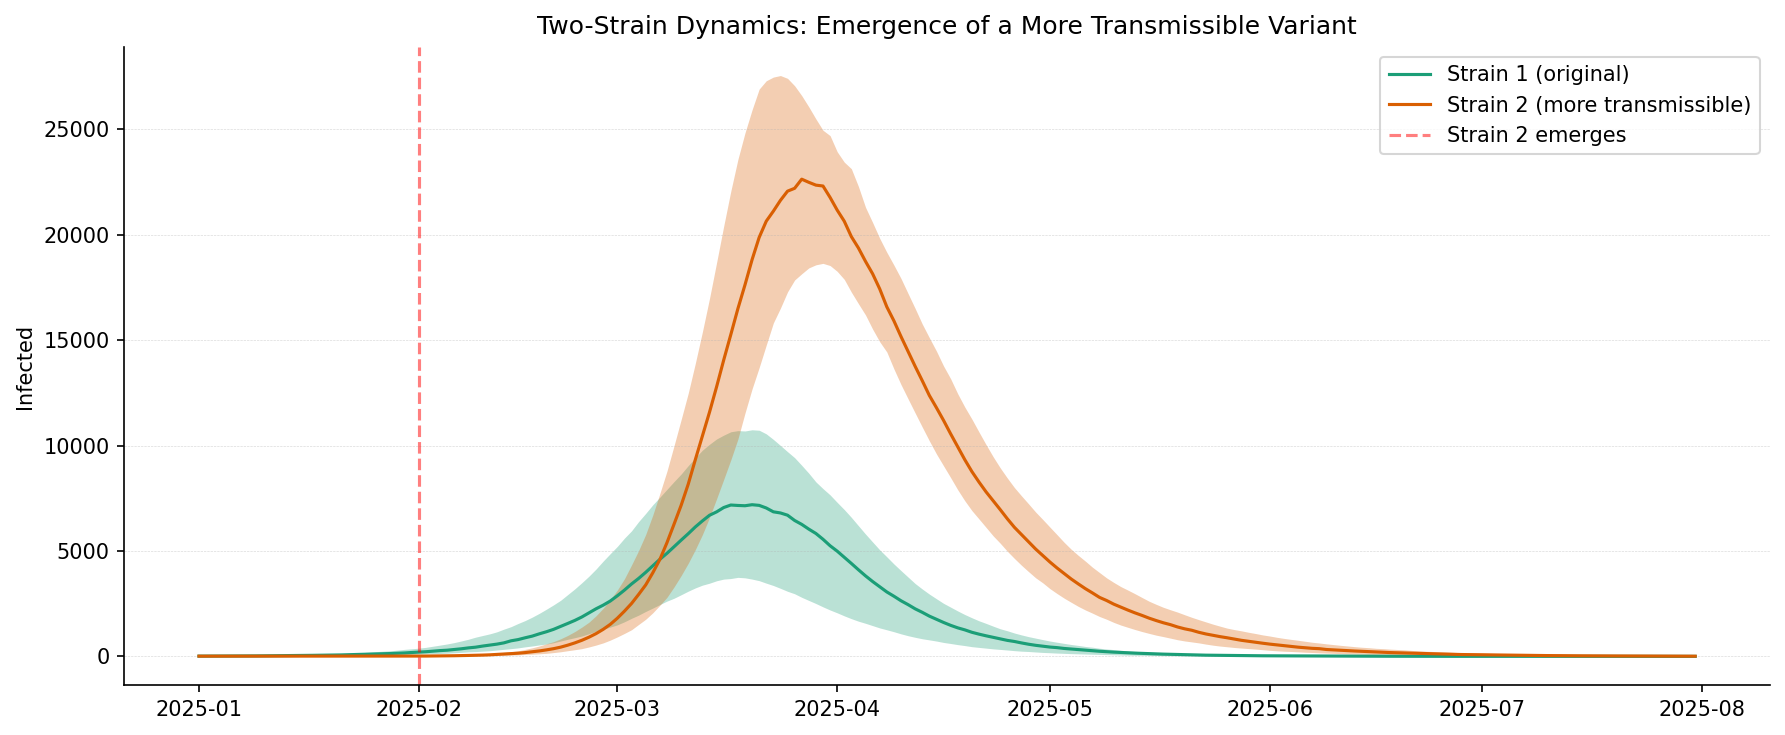

In [5]:
from epydemix.visualization import plot_quantiles
import pandas as pd

df_quantiles = results.get_quantiles_compartments()

# Plot both strains
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

plot_quantiles(df_quantiles, columns=["I1_total"], ax=ax,
               colors=colors[0], labels=["Strain 1 (original)"])
plot_quantiles(df_quantiles, columns=["I2_total"], ax=ax,
               colors=colors[1], labels=["Strain 2 (more transmissible)"])

# Mark emergence date
ax.axvline(pd.to_datetime("2025-02-01"), color="red", linestyle="--", alpha=0.5, label="Strain 2 emerges")

ax.set_title("Two-Strain Dynamics: Emergence of a More Transmissible Variant")
ax.set_ylabel("Infected")
ax.legend()

plt.tight_layout()

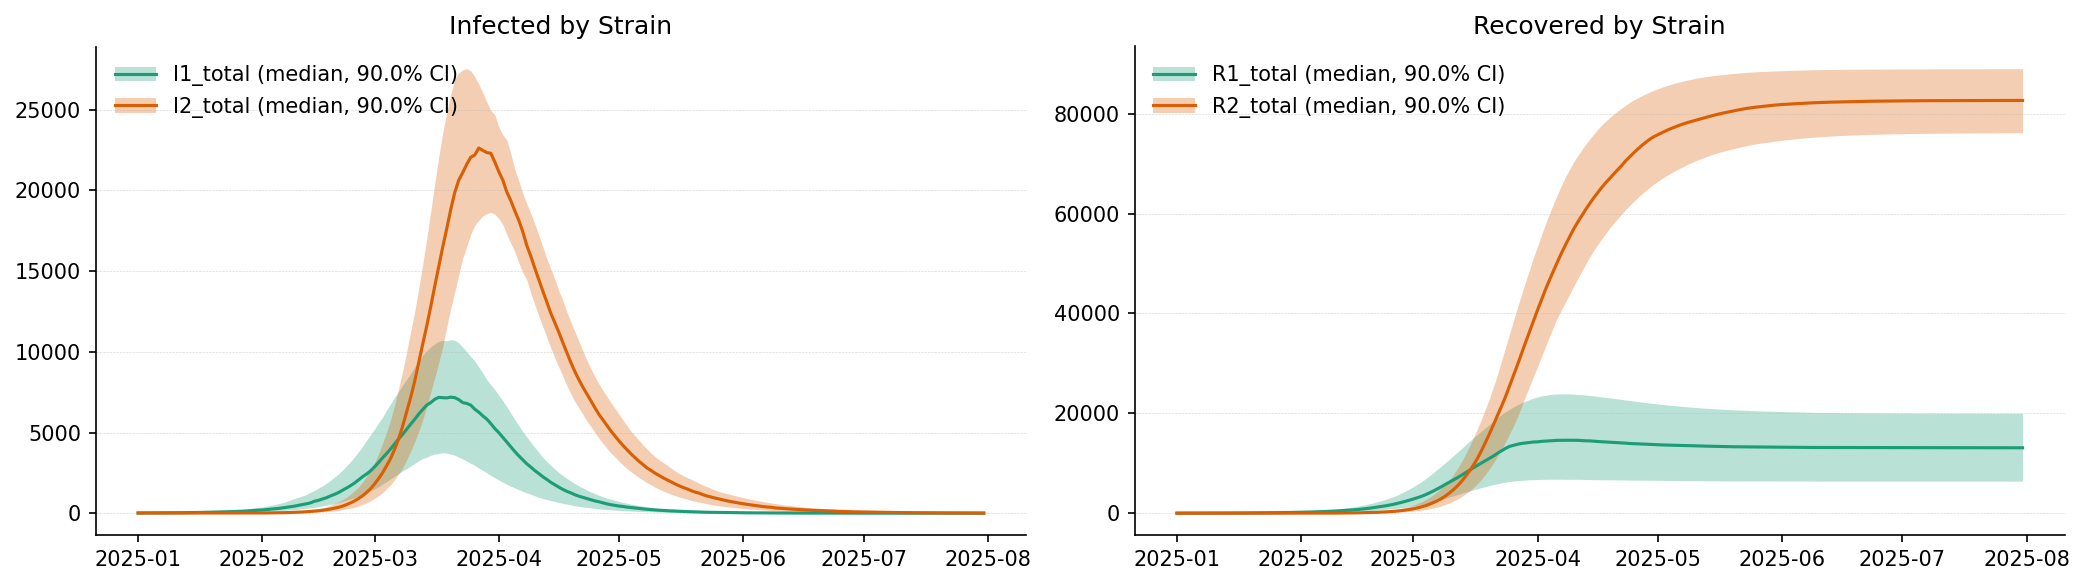

In [6]:
# Plot all compartments
fig, axes = plt.subplots(1, 2, figsize=(14, 4), dpi=150)

# Infected
plot_quantiles(df_quantiles, columns=["I1_total", "I2_total"], ax=axes[0],
               title="Infected by Strain")

# Recovered
plot_quantiles(df_quantiles, columns=["R1_total", "R2_total"], ax=axes[1],
               title="Recovered by Strain")

plt.tight_layout()

## Task 4: Experiments

### Experiment A: Effect of Emergence Timing

In [7]:
def run_with_emergence_day(emergence_day):
    """Run simulation with strain 2 emerging on a specific day."""
    model = create_two_strain_model(psi=1.5, gamma=0.4)
    
    # Calculate emergence date
    from datetime import datetime, timedelta
    start = datetime(2025, 1, 1)
    emergence_date = (start + timedelta(days=emergence_day)).strftime("%Y-%m-%d")
    
    # Override until emergence
    model.override_parameter(
        start_date="2025-01-01",
        end_date=emergence_date,
        parameter_name="psi",
        value=0.0
    )
    model.override_parameter(
        start_date="2025-01-01",
        end_date=emergence_date,
        parameter_name="mu2",
        value=0.0
    )
    
    results = model.run_simulations(
        start_date="2025-01-01",
        end_date="2025-07-31",
        Nsim=50,
        initial_conditions_dict={
            "S": model.population.Nk - np.ones(1) * 20,
            "I1": np.ones(1) * 10,
            "I2": np.ones(1) * 10,
            "R1": np.zeros(1),
            "R2": np.zeros(1)
        }
    )
    
    return results, emergence_date

# Run with different emergence times
results_early, date_early = run_with_emergence_day(15)   # Day 15
results_mid, date_mid = run_with_emergence_day(30)       # Day 30
results_late, date_late = run_with_emergence_day(45)     # Day 45

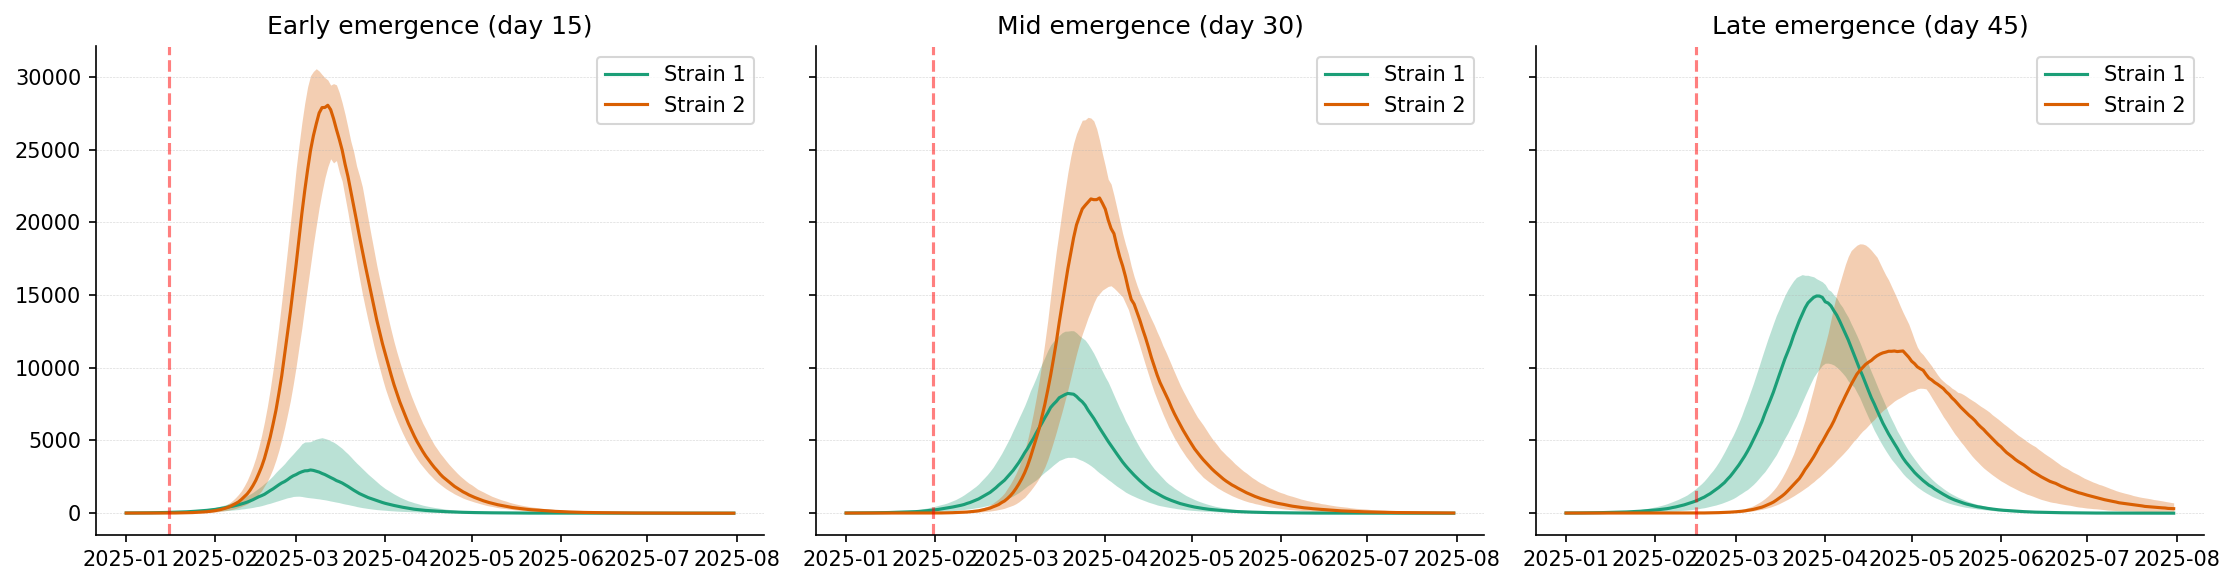

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=150, sharey=True)

for ax, results, title, emergence_date in [
    (axes[0], results_early, "Early emergence (day 15)", date_early),
    (axes[1], results_mid, "Mid emergence (day 30)", date_mid),
    (axes[2], results_late, "Late emergence (day 45)", date_late)
]:
    df = results.get_quantiles_compartments()
    plot_quantiles(df, columns=["I1_total"], ax=ax, colors=colors[0], labels=["Strain 1"])
    plot_quantiles(df, columns=["I2_total"], ax=ax, colors=colors[1], labels=["Strain 2"])
    ax.axvline(pd.to_datetime(emergence_date), color="red", linestyle="--", alpha=0.5)
    ax.set_title(title)
    ax.legend(loc="upper right")

plt.tight_layout()

### Experiment B: Effect of Transmissibility Advantage

In [9]:
def run_with_psi(psi_value):
    """Run simulation with different transmissibility advantage."""
    model = create_two_strain_model(psi=psi_value, gamma=0.4)
    
    model.override_parameter(
        start_date="2025-01-01",
        end_date="2025-01-31",
        parameter_name="psi",
        value=0.0
    )
    model.override_parameter(
        start_date="2025-01-01",
        end_date="2025-01-31",
        parameter_name="mu2",
        value=0.0
    )
    
    results = model.run_simulations(
        start_date="2025-01-01",
        end_date="2025-07-31",
        Nsim=50,
        initial_conditions_dict={
            "S": model.population.Nk - np.ones(1) * 20,
            "I1": np.ones(1) * 10,
            "I2": np.ones(1) * 10,
            "R1": np.zeros(1),
            "R2": np.zeros(1)
        }
    )
    
    return results

# Run with different psi values
results_psi_low = run_with_psi(1.2)    # 20% more transmissible
results_psi_mid = run_with_psi(1.5)    # 50% more transmissible
results_psi_high = run_with_psi(2.0)   # 100% more transmissible

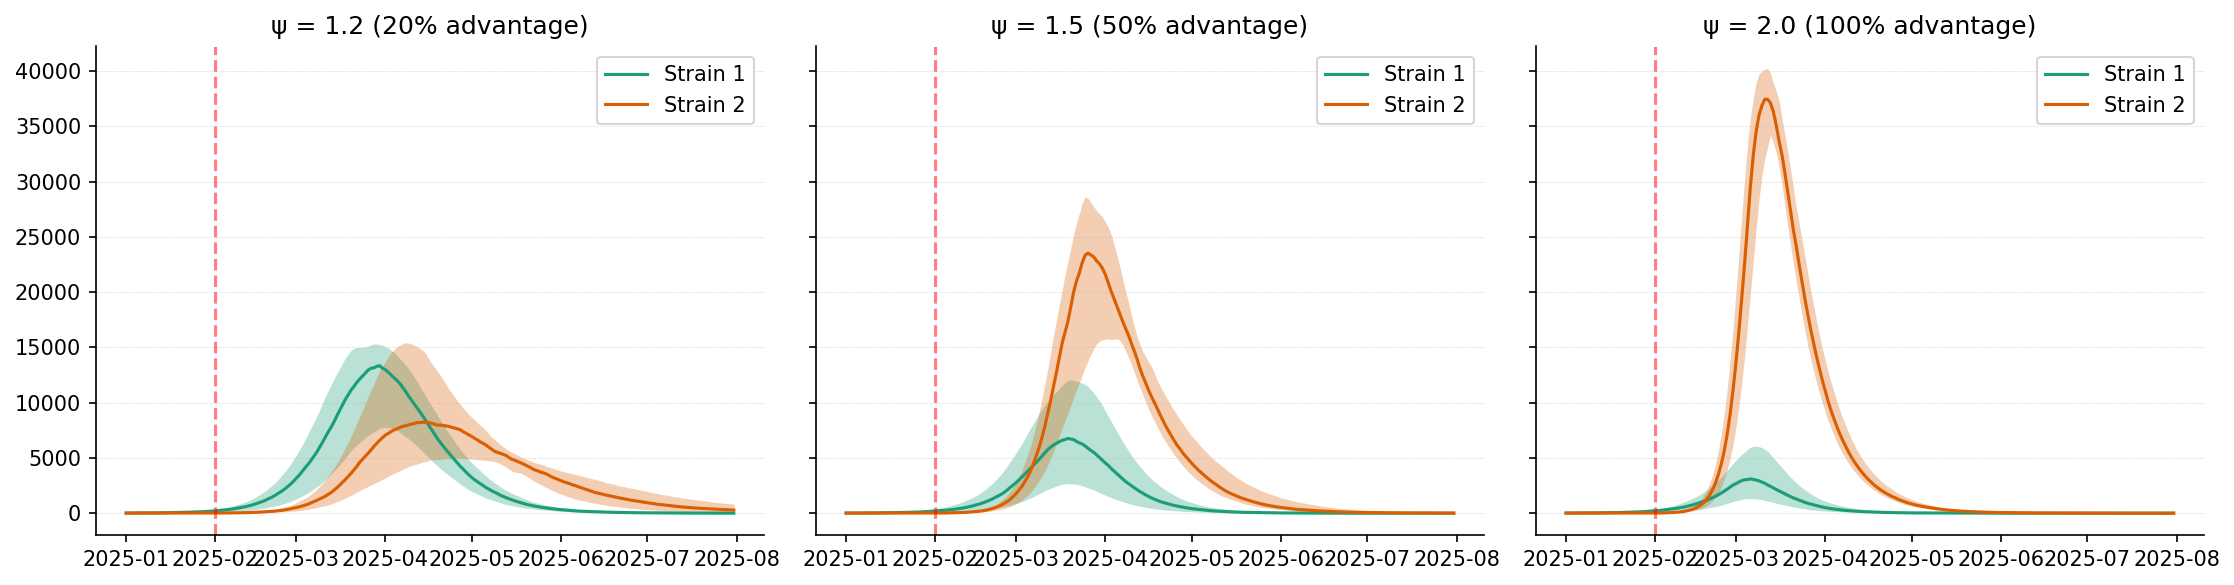

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=150, sharey=True)

for ax, results, title in [
    (axes[0], results_psi_low, "ψ = 1.2 (20% advantage)"),
    (axes[1], results_psi_mid, "ψ = 1.5 (50% advantage)"),
    (axes[2], results_psi_high, "ψ = 2.0 (100% advantage)")
]:
    df = results.get_quantiles_compartments()
    plot_quantiles(df, columns=["I1_total"], ax=ax, colors=colors[0], labels=["Strain 1"])
    plot_quantiles(df, columns=["I2_total"], ax=ax, colors=colors[1], labels=["Strain 2"])
    ax.axvline(pd.to_datetime("2025-02-01"), color="red", linestyle="--", alpha=0.5)
    ax.set_title(title)
    ax.legend(loc="upper right")

plt.tight_layout()

In [11]:
# Compute when strain 2 becomes dominant
def compute_dominance_day(results):
    """Find the day when strain 2 exceeds strain 1."""
    traj = results.get_stacked_compartments()
    I1_median = np.median(traj["I1_total"], axis=0)
    I2_median = np.median(traj["I2_total"], axis=0)
    
    # Find first day where I2 > I1 (after emergence)
    crossover = np.where((I2_median > I1_median) & (I2_median > 100))[0]
    if len(crossover) > 0:
        return crossover[0]
    return None

print("Days until strain 2 dominance:")
print(f"  ψ = 1.2: Day {compute_dominance_day(results_psi_low)}")
print(f"  ψ = 1.5: Day {compute_dominance_day(results_psi_mid)}")
print(f"  ψ = 2.0: Day {compute_dominance_day(results_psi_high)}")

Days until strain 2 dominance:
  ψ = 1.2: Day 105
  ψ = 1.5: Day 65
  ψ = 2.0: Day 49


## Discussion

**Key observations:**

1. **Emergence timing matters:**
   - Early emergence: Strain 2 quickly takes over before strain 1 depletes susceptibles
   - Late emergence: Strain 1 has already infected much of the population, leaving fewer susceptibles for strain 2
   - However, strain 2 can still spread among R₁ individuals (reinfection)

2. **Transmissibility advantage (ψ):**
   - Higher ψ → faster strain replacement
   - Even modest advantages (20%) lead to eventual dominance
   - This explains why SARS-CoV-2 variants (Alpha, Delta, Omicron) successively replaced each other

3. **Cross-immunity (γ):**
   - γ = 0.4 means R₁ individuals have 60% protection against strain 2
   - This partial protection slows but doesn't prevent strain 2 spread
   - If γ = 0 (complete cross-protection), strain 2 could only infect remaining susceptibles

**Real-world implications:**
- Early detection of new variants is crucial for pandemic response
- Vaccines that provide cross-variant protection can slow variant emergence
- Even small transmissibility advantages compound over time through exponential growth